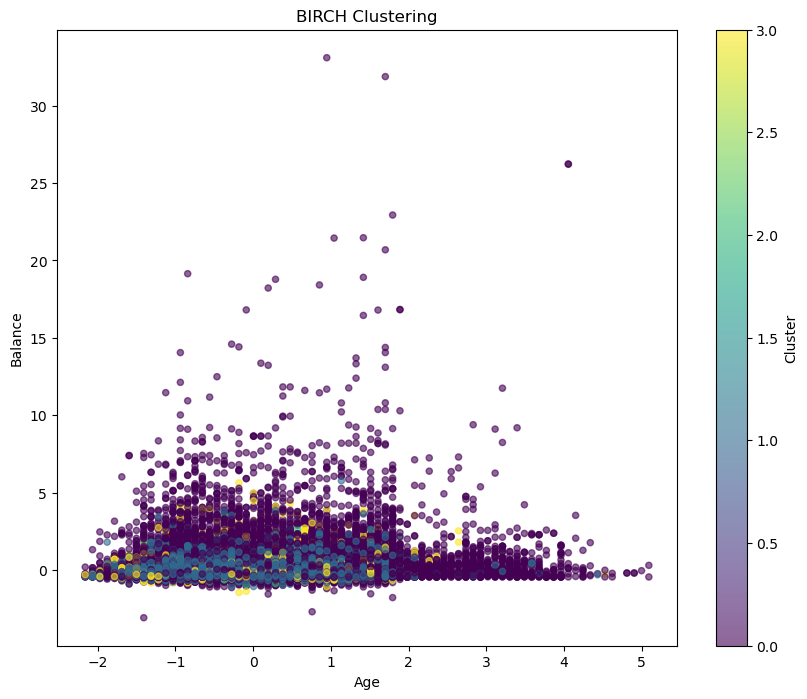

Cluster Summary (Numerical Features):
                 y       age   balance  day_of_week  duration  campaign  \
Cluster                                                                  
0        0.067370  0.066488  0.045084     0.007229 -0.270209 -0.077193   
1        0.202766 -0.201337 -0.126082    -0.166196 -0.017595 -0.228318   
2        0.010274 -0.097197 -0.141779     0.822804 -0.581514  5.007994   
3        0.341133 -0.146012 -0.099595     0.029356  1.854934 -0.069172   

            pdays  previous  
Cluster                      
0       -0.340373 -0.199038  
1        2.019618  1.187573  
2       -0.409652 -0.250454  
3       -0.389866 -0.234698  
Cluster Mode (Categorical Features):
                  job  marital  education default housing loan   contact month
Cluster                                                                      
0        blue-collar  married  secondary      no     yes   no  cellular   may
1         management  married  secondary      no     yes   no  c

In [1]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

# 1. 导入数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

# 将目标变量 y 合并到 X 中，确保可以进行目标编码
X['y'] = y

# 将 'y' 转换为数值型：'yes' -> 1, 'no' -> 0
X['y'] = X['y'].map({'yes': 1, 'no': 0})

# 2. 识别数值特征和类别特征
numerical_cols = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

# 3. 对数值特征进行标准化
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 4. 合并类别特征：将低频类别合并为 'other'
def merge_low_frequency_categories(df, columns, threshold=100):
    for col in columns:
        value_counts = df[col].value_counts()
        low_freq_categories = value_counts[value_counts < threshold].index
        df[col] = df[col].replace(low_freq_categories, 'other')
    return df

# 处理类别特征，合并低频类别
X = merge_low_frequency_categories(X, ['job', 'month'], threshold=100)

# 5. 目标编码：对月份特征进行目标编码（按订阅率计算均值）
month_target_encoding = X.groupby('month')['y'].mean()  # 按月计算订阅率的均值
X['month_encoded'] = X['month'].map(month_target_encoding)  # 将编码值映射到数据中

# 6. 目标编码：对job特征进行目标编码（按订阅率计算均值）
job_target_encoding = X.groupby('job')['y'].mean()  # 按job计算订阅率的均值
X['job_encoded'] = X['job'].map(job_target_encoding)  # 将编码值映射到数据中

# 7. 处理其他类别特征：对其他类别特征进行One-Hot编码
X_processed = pd.get_dummies(X[categorical_cols], drop_first=True)  # One-Hot编码
X_processed[numerical_cols] = X[numerical_cols]  # 将数值特征合并进来

# 8. 使用 BIRCH 进行聚类
birch = Birch(n_clusters=4, threshold=0.5, branching_factor=50)
clusters_birch = birch.fit_predict(X_processed)

# 可视化聚类结果（使用 UMAP 降维后的数据）
plt.figure(figsize=(10, 8))
plt.scatter(X_processed['age'], X_processed['balance'], c=clusters_birch, cmap='viridis', s=20, alpha=0.6)
plt.title('BIRCH Clustering')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.colorbar(label='Cluster')
plt.show()

# 9. 聚类分析：查看每个簇的订阅率（y）和特征均值
X_raw = X.copy()
X_raw['Cluster'] = clusters_birch

# 聚类统计信息（数值特征均值）
cluster_summary = X_raw.groupby('Cluster').agg({
    'y': 'mean',  # 计算每个簇的订阅率均值
    **{col: 'mean' for col in numerical_cols}  # 计算每个簇的数值型特征均值
})
print("Cluster Summary (Numerical Features):\n", cluster_summary)

# 聚类统计信息（类别特征的众数）
cluster_mode = X_raw.groupby('Cluster').agg({
    **{col: lambda x: x.mode()[0] for col in categorical_cols}  # 计算每个簇的类别特征的众数
})
print("Cluster Mode (Categorical Features):\n", cluster_mode)

# 10. 评估 BIRCH 聚类效果：计算轮廓系数（Silhouette Score）
silhouette_avg = silhouette_score(X_processed, clusters_birch)
print(f"Silhouette Score for BIRCH: {silhouette_avg:.4f}")

# 11. 评估 BIRCH 聚类效果：计算 Davies-Bouldin指数
db_score = davies_bouldin_score(X_processed, clusters_birch)
print(f"Davies-Bouldin Score for BIRCH: {db_score:.4f}")

# 12. 评估 BIRCH 聚类效果：计算 Calinski-Harabasz指数
ch_score = calinski_harabasz_score(X_processed, clusters_birch)
print(f"Calinski-Harabasz Score for BIRCH: {ch_score:.4f}")

# 13. 保存最终聚类结果
X_raw.to_csv('birch_clustered_data.csv', index=False)


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3965 - val_loss: 0.2782
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2565 - val_loss: 0.2249
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2133 - val_loss: 0.1980
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1863 - val_loss: 0.1823
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1871 - val_loss: 0.1731
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1752 - val_loss: 0.1669
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1636 - val_loss: 0.1626
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1565 - val_loss: 0.1593
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1566 - val_loss: 0.1566
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1565 - val_loss: 0.1543
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1612 - val_loss: 0.1523
Epoch 12/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

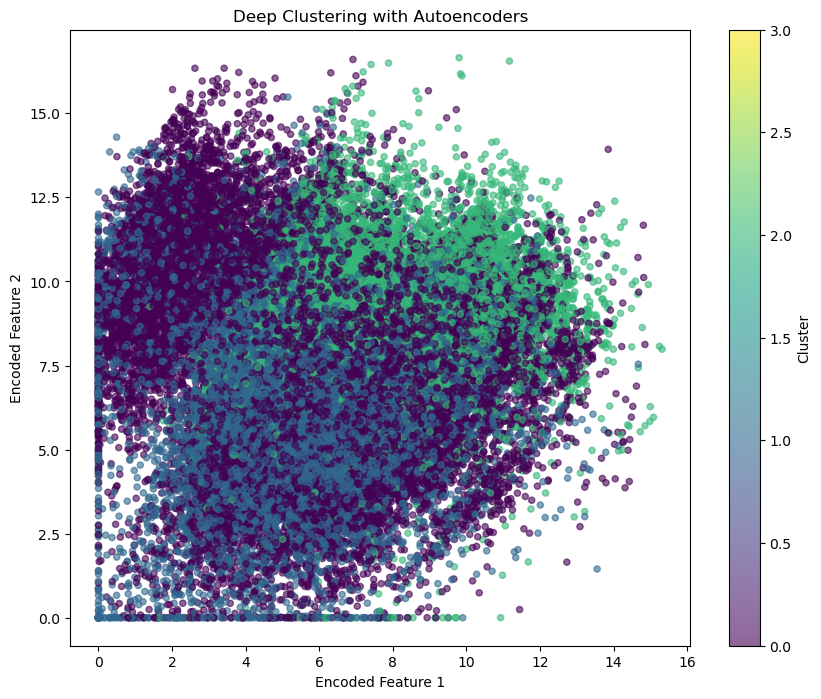

Cluster Summary (Numerical Features):
                 y       age   balance  day_of_week  duration  campaign  \
Cluster                                                                  
0        0.121258  0.117802 -0.010176     0.035099 -0.008487  0.092005   
1        0.203589  0.006760  0.053655    -0.183116 -0.012141 -0.235364   
2        0.064506 -0.234635 -0.007330     0.024488  0.022811 -0.060699   
3        0.000000 -0.088167 -0.269079    -1.658950  0.352731 -0.246560   

            pdays    previous  
Cluster                        
0       -0.346047   -0.224184  
1        2.019751    1.302209  
2       -0.349506   -0.232270  
3        2.215194  119.135982  
Cluster Mode (Categorical Features):
                  job  marital  education default housing loan   contact month
Cluster                                                                      
0         management  married  secondary      no      no   no  cellular   jul
1         management  married  secondary      no    

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from ucimlrepo import fetch_ucirepo

# 1. 导入数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

# 将目标变量 y 合并到 X 中，确保可以进行目标编码
X['y'] = y

# 将 'y' 转换为数值型：'yes' -> 1, 'no' -> 0
X['y'] = X['y'].map({'yes': 1, 'no': 0})

# 2. 识别数值特征和类别特征
numerical_cols = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

# 3. 对数值特征进行标准化
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


# 5. 目标编码：对月份特征进行目标编码（按订阅率计算均值）
month_target_encoding = X.groupby('month')['y'].mean()  # 按月计算订阅率的均值
X['month_encoded'] = X['month'].map(month_target_encoding)  # 将编码值映射到数据中

# 6. 目标编码：对job特征进行目标编码（按订阅率计算均值）
job_target_encoding = X.groupby('job')['y'].mean()  # 按job计算订阅率的均值
X['job_encoded'] = X['job'].map(job_target_encoding)  # 将编码值映射到数据中

# 7. 处理其他类别特征：对其他类别特征进行One-Hot编码
X_processed = pd.get_dummies(X[categorical_cols], drop_first=True)  # One-Hot编码
X_processed[numerical_cols] = X[numerical_cols]  # 将数值特征合并进来

# 8. 自编码器（Autoencoder）模型定义
input_dim = X_processed.shape[1]
encoding_dim = 10  # 降到10维

# 定义编码器和解码器
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# 创建自编码器模型
autoencoder = tf.keras.Model(input_layer, decoded)
encoder = tf.keras.Model(input_layer, encoded)

# 编译并训练自编码器
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_processed, X_processed, epochs=50, batch_size=256, shuffle=True, validation_data=(X_processed, X_processed))

# 9. 获取低维表示
encoded_data = encoder.predict(X_processed)

# 10. 使用 K-Means 对低维数据进行聚类
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_autoencoder = kmeans.fit_predict(encoded_data)

# 11. 可视化聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters_autoencoder, cmap='viridis', s=20, alpha=0.6)
plt.title('Deep Clustering with Autoencoders')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# 12. 聚类分析：查看每个簇的订阅率（y）和特征均值
X_raw = X.copy()
X_raw['Cluster'] = clusters_autoencoder

# 聚类统计信息（数值特征均值）
cluster_summary = X_raw.groupby('Cluster').agg({
    'y': 'mean',  # 计算每个簇的订阅率均值
    **{col: 'mean' for col in numerical_cols}  # 计算每个簇的数值特征均值
})
print("Cluster Summary (Numerical Features):\n", cluster_summary)

# 聚类统计信息（类别特征的众数）
cluster_mode = X_raw.groupby('Cluster').agg({
    **{col: lambda x: x.mode()[0] for col in categorical_cols}  # 计算每个簇的类别特征的众数
})
print("Cluster Mode (Categorical Features):\n", cluster_mode)

# 13. 评估聚类效果：计算轮廓系数（Silhouette Score）
silhouette_avg = silhouette_score(encoded_data, clusters_autoencoder)
print(f"Silhouette Score for Deep Clustering with Autoencoders: {silhouette_avg:.4f}")

# 14. 评估聚类效果：计算 Davies-Bouldin指数
db_score = davies_bouldin_score(encoded_data, clusters_autoencoder)
print(f"Davies-Bouldin Score for Deep Clustering with Autoencoders: {db_score:.4f}")

# 15. 评估聚类效果：计算 Calinski-Harabasz指数
ch_score = calinski_harabasz_score(encoded_data, clusters_autoencoder)
print(f"Calinski-Harabasz Score for Deep Clustering with Autoencoders: {ch_score:.4f}")

# 16. 保存最终聚类结果
X_raw.to_csv('autoencoder_clustered_data.csv', index=False)
